### Created by: Anthony D. Cho
### Last update: 28.10.2021

**Subject**: Classification (RandomForest, Adaboost, GBM, XGBM) - Applied to Breast Cancer Coimbra


## Library dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from pandas import read_csv
from numpy import arange

## Pre-processing functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

## Tree display
from sklearn.tree import plot_tree

## Cross-Validation
from sklearn.model_selection import StratifiedShuffleSplit

## Search
from sklearn.model_selection import GridSearchCV

## Metrics
from sklearn.metrics import classification_report, plot_confusion_matrix

## Customized function

In [2]:
def plot_feature_importances(model, features, width=10, height=6):
    """
        DESCRIPTION:
            Feature importance display function
        
        INPUT:
            @param model: Decision tree regression model
            @type model: sklearn.DecisionTreeRegressor
            
            @param features: feature names
            @type features: list
            
            @param width: width of the display space (default 10)
            @type width: int
            
            @param height: height of the display space (default 8)
            @type height: int
        
        OUTPUT:
            A graphic of feature importance
    """
    
    ## Number of features
    n_features = len(features)
    
    ## Feature importance display
    plt.figure(figsize=(width, height))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

# Problem: Breast Cancer Coimbra

**Target**: Classification (0: No, 1: Yes)

## Data loading

Source: [Breast Cancer Coimbra](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra)

In [3]:
## Load data
data = read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv')

## Feature names list
feature_names = data.columns[:-1]

In [4]:
## Data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  
 3   Insulin         116 non-null    float64
 4   HOMA            116 non-null    float64
 5   Leptin          116 non-null    float64
 6   Adiponectin     116 non-null    float64
 7   Resistin        116 non-null    float64
 8   MCP.1           116 non-null    float64
 9   Classification  116 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 9.2 KB


In [5]:
## data description
data.describe(include='all')

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,1.551724
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,1.000000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474282,6.881763,269.978250,1.000000
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,2.000000
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


In [6]:
data.head(4)

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1


## Data pre-processing

In [7]:
## Predictors and target assignment
X = data.drop(columns=['Classification'])
y = data['Classification']

## Partition sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20200803)

## Standardizing
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

## Display data shape
print('(train shape) X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('(test shape) X: {}, y: {}'.format(X_test.shape, y_test.shape))

(train shape) X: (87, 9), y: (87,)
(test shape) X: (29, 9), y: (29,)


## Random Forest + Gridsearch

In [8]:
start = time()

## Cross-Validation's method instance
cvs = StratifiedShuffleSplit(n_splits=5, train_size=0.7)

## Parameter-space for searching
param ={'min_samples_split': arange(1, 25),
        'max_depth': arange(1, 10)
       }

## Best model estimation by gridsearchcv
GS = GridSearchCV(estimator=RandomForestClassifier(criterion='entropy', n_estimators=50), 
                  cv=cvs, n_jobs=-1, 
                  param_grid=param,
                  scoring='roc_auc').fit(X=X_train, y=y_train)

## Display best model's hyperparameters
print('Best hyperparameters: {}'.format(GS.best_params_))

timeUp = time()-start
print('Time spent: {:.2f} seconds'.format(timeUp))

Best hyperparameters: {'max_depth': 7, 'min_samples_split': 3}
Time spent: 40.63 seconds


In [9]:
## Compute score
GS.score(X_test, y_test)

0.7107843137254902

gini (Train): 1.0000
gini (Test): 0.6552


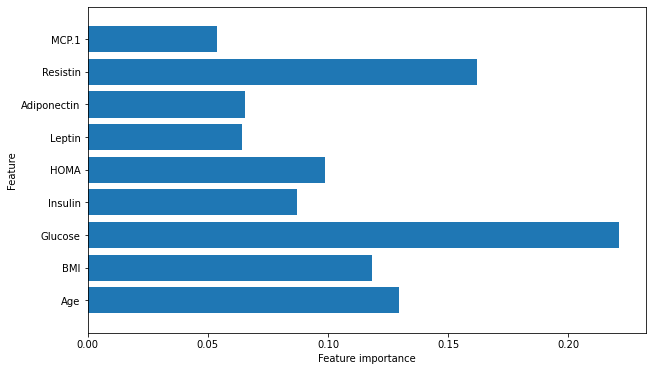

In [10]:
## Fitting a model with best parameters
model = RandomForestClassifier(**GS.best_params_).fit(X=X_train, y=y_train)

## Compute score using train set
print('{} (Train): {:.4f}'.format(model.criterion, model.score(X=X_train, y=y_train)))

## Compute score using test set
print('{} (Test): {:.4f}'.format(model.criterion, model.score(X=X_test, y=y_test)))

## feature importances display
plot_feature_importances(model, feature_names)


              precision    recall  f1-score   support

           1       0.58      0.58      0.58        12
           2       0.71      0.71      0.71        17

    accuracy                           0.66        29
   macro avg       0.64      0.64      0.64        29
weighted avg       0.66      0.66      0.66        29



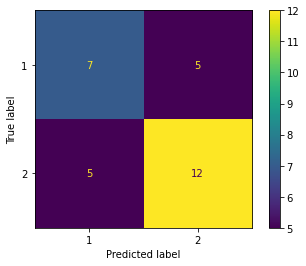

In [11]:
## compute prediction
prediction = model.predict(X_test)

## display classification report
print(classification_report(y_pred=prediction, y_true=y_test))

## Display confusion matrix
plot_confusion_matrix(estimator=model, X=X_test, y_true=y_test);

## Ada Boost Classifier

In [12]:
start = time()

## Cross-Validation's method instance
cvs = StratifiedShuffleSplit(n_splits=5, train_size=0.7)

## Parameter-space for searching
param ={'n_estimators': arange(25, 100, 5),
        'learning_rate': arange(0.1, 1.1, 0.1)
       }

## Best model estimation by gridsearchcv
GS = GridSearchCV(estimator=AdaBoostClassifier(), 
                  cv=cvs, n_jobs=-1, 
                  param_grid=param,
                  scoring='roc_auc').fit(X=X_train, y=y_train)

## Display best model's hyperparameters
print('Best hyperparameters: {}'.format(GS.best_params_))

timeUp = time()-start
print('Time spent: {:.2f} seconds'.format(timeUp))

Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 55}
Time spent: 34.66 seconds


In [13]:
## Compute score
GS.score(X_test, y_test)

0.7352941176470589

(Train): 0.9310
(Test): 0.7241


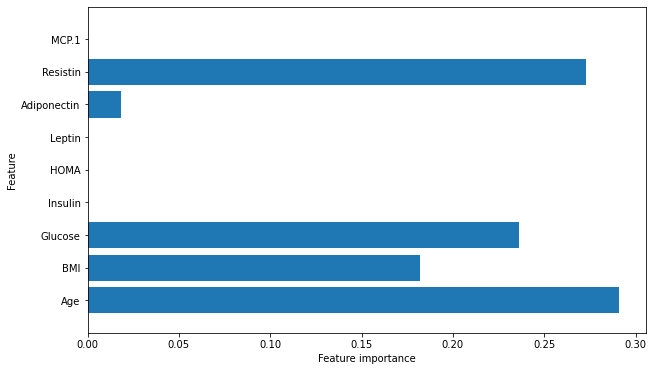

In [14]:
## Fitting a model with best parameters
model = AdaBoostClassifier(**GS.best_params_).fit(X=X_train, y=y_train)

## Compute score using train set
print('(Train): {:.4f}'.format(model.score(X=X_train, y=y_train)))

## Compute score using test set
print('(Test): {:.4f}'.format(model.score(X=X_test, y=y_test)))

## feature importances display
plot_feature_importances(model, feature_names)


              precision    recall  f1-score   support

           1       0.75      0.50      0.60        12
           2       0.71      0.88      0.79        17

    accuracy                           0.72        29
   macro avg       0.73      0.69      0.69        29
weighted avg       0.73      0.72      0.71        29



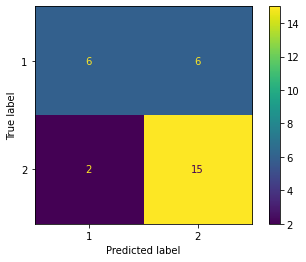

In [15]:
## compute prediction
prediction = model.predict(X_test)

## display classification report
print(classification_report(y_pred=prediction, y_true=y_test))

## Display confusion matrix
plot_confusion_matrix(estimator=model, X=X_test, y_true=y_test);

## Gradient Boosting Machine

In [16]:
start = time()

## Cross-Validation's method instance
cvs = StratifiedShuffleSplit(n_splits=5, train_size=0.7)

## Parameter-space for searching
param ={'n_estimators': arange(25, 200, 25),
        'learning_rate': arange(0.1, 1.1, 0.1),
        'subsample': [0.5, 0.75, 1.0], 
        'max_depth': arange(1,5)
       }

## Best model estimation by gridsearchcv
GS = GridSearchCV(estimator=GradientBoostingClassifier(), 
                  cv=cvs, n_jobs=-1, 
                  param_grid=param,
                  scoring='roc_auc').fit(X=X_train, y=y_train)

## Display best model's hyperparameters
print('Best hyperparameters: {}'.format(GS.best_params_))

timeUp = time()-start
print('Time spent: {:.2f} seconds'.format(timeUp))

Best hyperparameters: {'learning_rate': 1.0, 'max_depth': 2, 'n_estimators': 25, 'subsample': 1.0}
Time spent: 133.47 seconds


In [17]:
## Compute score
GS.score(X_test, y_test)

0.6715686274509804

(Train): 1.0000
(Test): 0.6207


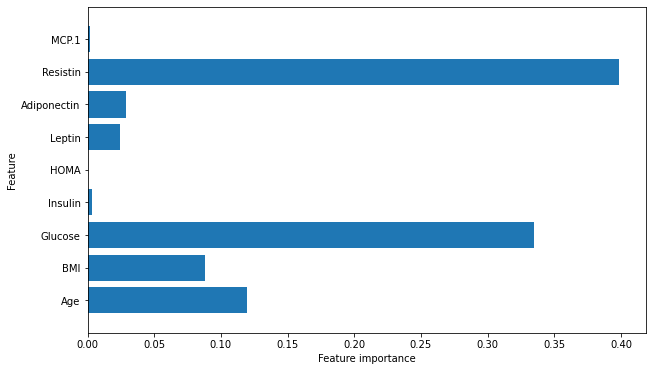

In [18]:
## Fitting a model with best parameters
model = GradientBoostingClassifier(**GS.best_params_).fit(X=X_train, y=y_train)

## Compute score using train set
print('(Train): {:.4f}'.format(model.score(X=X_train, y=y_train)))

## Compute score using test set
print('(Test): {:.4f}'.format(model.score(X=X_test, y=y_test)))

## feature importances display
plot_feature_importances(model, feature_names)

              precision    recall  f1-score   support

           1       0.54      0.58      0.56        12
           2       0.69      0.65      0.67        17

    accuracy                           0.62        29
   macro avg       0.61      0.62      0.61        29
weighted avg       0.63      0.62      0.62        29



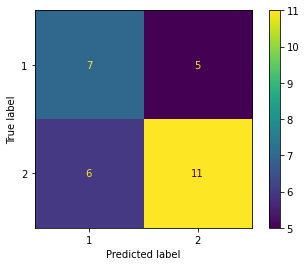

In [19]:
## compute prediction
prediction = model.predict(X_test)

## display classification report
print(classification_report(y_pred=prediction, y_true=y_test))

## Display confusion matrix
plot_confusion_matrix(estimator=model, X=X_test, y_true=y_test);

## Extreme Gradient Boosting Machine

    - PKG Version 0.90

Hyperparameters' list:
https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

In [20]:
start = time()

## Cross-Validation's method instance
cvs = StratifiedShuffleSplit(n_splits=5, train_size=0.7)

## Parameter-space for searching
param ={'n_estimators': arange(25, 200, 25),
        'learning_rate': arange(0.1, 1.1, 0.1),
        'subsample': [0.5, 0.75, 1.0], 
        'max_depth': arange(1,5)
       }

## Best model estimation by gridsearchcv
GS = GridSearchCV(estimator=xgb.XGBClassifier(), 
                  cv=cvs, n_jobs=-1, 
                  param_grid=param,
                  scoring='roc_auc', refit=True,
                  ).fit(X=X_train, y=y_train)

## Display best model's hyperparameters
print('Best hyperparameters: {}'.format(GS.best_params_))

timeUp = time()-start
print('Time spent: {:.2f} seconds'.format(timeUp))

Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 25, 'subsample': 1.0}
Time spent: 25.42 seconds


In [21]:
## Compute score
GS.score(X_test, y_test)

0.7598039215686274

(Train): 1.0000
(Test): 0.7586


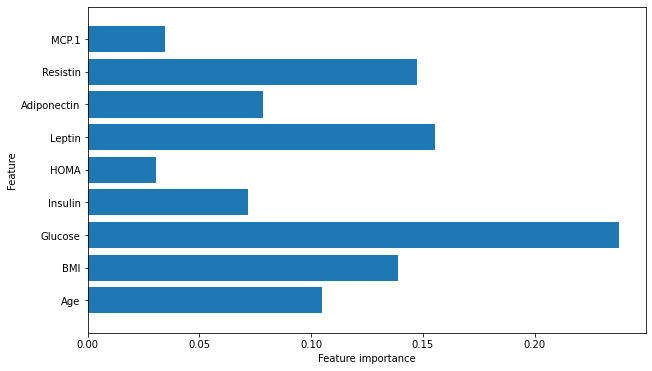

In [22]:
## Fitting a model with best parameters
#model = xgb.XGBClassifier(**GS.best_params_).fit(X=X_train, y=y_train)
model = xgb.XGBClassifier().fit(X=X_train, y=y_train)

## Compute score using train set
print('(Train): {:.4f}'.format(model.score(X=X_train, y=y_train)))

## Compute score using test set
print('(Test): {:.4f}'.format(model.score(X=X_test, y=y_test)))

## feature importances display
plot_feature_importances(model, feature_names)

              precision    recall  f1-score   support

           1       0.73      0.67      0.70        12
           2       0.78      0.82      0.80        17

    accuracy                           0.76        29
   macro avg       0.75      0.75      0.75        29
weighted avg       0.76      0.76      0.76        29



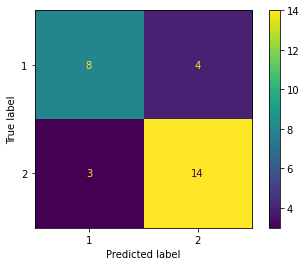

In [23]:
## compute prediction
prediction = model.predict(X_test)

## display classification report
print(classification_report(y_pred=prediction, y_true=y_test))

## Display confusion matrix
plot_confusion_matrix(estimator=model, X=X_test, y_true=y_test);